In [1]:
# -*- coding: utf-8 -*-

# ! pip install cyipopt numpy matplotlib scipy pandas

"""
Simulation of LTHS of a single-reservoir system
"""

import os
from time import time
import six
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cyipopt
from datetime import datetime, timedelta
from calendar import month_abbr


class ModelParameters:
    ''' 
    Class with hydropower plant parameters
        -  tail_coef is an array [a0,a1,a2,a3,a4] with coefficients of tailrace elevation
            function: h_tail(q) = a0 + a1x + a2x^2 + a3x^3 + a4x^4.
        -  for_coef is an array [a0,a1,a2,a3,a4] with coefficients of forebay elevation 
            function: h_for(x) = a0 + a1x + a2x^2 + a3x^3 + a4x^4.
    '''
    def __init__(self, name, demand, xmin, xmax, qmin, qmax, av_efficiency, tail_coef,
                 for_coef):
        self.name = name
        self.k = av_efficiency  #k^{ef} [MW/(m^3/s)/m]
        self.demand = demand    #k^{dem} load demand [MW]
        self.xmin = xmin  # min. storage [hm3]
        self.xmax = xmax  # max. storage [hm3]
        self.qmin = qmin  # min. discharge [m3/s]
        self.qmax = qmax  # max. discharge [m3/s]
        self.tail_coef = tail_coef  # tailrace elevation coefficients [m]
        self.for_coef = for_coef  # forebay elevation coefficients [m]
        self.c = 0.0002  # cost constant [$]
        self.kconv = (86400/(10**6))*np.array([31,28,31,30,31,30,31,31,30,31,30,31]) # k^{con} for conversion of units
        self.vaz = self.get_inflows()
        self.w_avg = self.get_inflows_avg()

    def efficiency(self, x0, q, v):
        ''' Efficiency function'''
        return self.k*(self.forebay_elevation(x0) - self.tailrace_elevation(q,v))

    def tailrace_elevation(self, discharge, spill):
        '''Tailrace elevation function'''
        return self.tail_coef[0] + self.tail_coef[1]*(discharge + spill) +\
            self.tail_coef[2]*(discharge + spill)** 2 +\
            self.tail_coef[3]*(discharge + spill)** 3 +\
            self.tail_coef[4]*(discharge + spill)**4

    def forebay_elevation(self, storage):
        '''Forebay elevation function'''
        return self.for_coef[0] + self.for_coef[1] * storage + \
            self.for_coef[2] * (storage ** 2) + self.for_coef[3] * (storage ** 3) + \
            self.for_coef[4]*(storage**4)

    def generation(self, storage, discharge, spill):
        '''Hydropower generation function'''
        return self.k * (self.forebay_elevation(storage) - \
            self.tailrace_elevation(discharge, spill))*discharge

    def present_cost(self, storage, discharge, spill, month):
        '''Quadratic operation cost'''
        return self.c * ((self.kconv[month] * 10 ** 6) / 3600) * (
            self.demand - self.generation(storage, discharge, spill))**2

    def f_objective(self, r, q, v, initial_month):
        '''Objective function - Average operation cost'''
        n = len(q)
        m = initial_month
        c = 0
        for i in range(n):
            c = self.present_cost(r[i], q[i], v[i], m) + c
            m = m + 1
            if m == 12:
                m = 0
        return c/n

    def forebay_deriv(self, x):
        ''' Derivative of forebay elevation function'''
        return self.for_coef[1] + 2 * self.for_coef[2] * x + \
            3*self.for_coef[3]*(x**2) + 4*self.for_coef[4]*(x**3)

    def tailrace_deriv(self, q, v):
        ''' Derivative of tailrace elevation function'''
        return self.tail_coef[1] + 2 * self.tail_coef[2] * (q + v) + \
            3*self.tail_coef[3]*(q+v)**2 + 4*self.tail_coef[4]*(q + v)**3

    def get_inflows(self):
        ''' Method to load historical inflows'''
        # ref_arq = open('path/to/data/vazoes_'+self.name+'.txt',"r")
        # ref_arq = open(os.path.join(data, 'vazoes_'+self.name+'.txt',"r"))
        diretorio = os.getcwd() + '/data'
        try:
            ref_arq = open('../data/vazoes_' + self.name + '.txt', "r", encoding="utf8")
        except:
            ref_arq = open(diretorio + '/vazoes_'+self.name+'.txt', "r", encoding="utf8")
        vaz=[]
        i=-1
        for linha in ref_arq:
            i+=1
            values = linha.split()
            values = [float(i) for i in values]
            vaz.append(values)
        ref_arq.close()
        return np.array(vaz)

    def get_inflows_avg(self):
        ''' Method to calculate monthly inflows mean'''
        return np.mean(self.vaz, axis=0)

In [2]:
class Prob:
    ''' Class of problem to be solved by the MPC optimizer '''
    def __init__(self, uhe, h, m_initial, r0, wpred):
        self.h = h  # optimization horizon (number of months)
        self.m_initial = m_initial  # initial month
        self.r0 = r0  # initial storage (hm^3)
        self.wpred = wpred  # inflow prediction (m^3/s)
        self.uhe = uhe  # hydro plant

    def objective(self, x):
        """ Objective function """
        r = x[0: self.h]  # storage vector (hm^3)
        q = x[self.h+1: 2*self.h+1]  # discharge (m^3/s)
        v = x[2*self.h+1:]  # spillage vector (m^3/s)
        return self.uhe.f_objective(r, q, v, self.m_initial)

    def gradient(self, x):
        """ Gradient function """
        r = x[0: self.h]
        q = x[self.h + 1: 2*self.h + 1]
        v = x[2*self.h + 1: ]
        grad1 = [None]*self.h
        grad2a = [None]*self.h
        grad2b = [None]*self.h
        grad2c = [None]*self.h
        m = self.m_initial
        for i in range(self.h):
            grad1[i] = 2 * self.uhe.k * self.uhe.c * ((10 ** 6) / 3600) * self.uhe.kconv[m] * (
                self.uhe.demand - self.uhe.k*(self.uhe.forebay_elevation(r[i]) -
                self.uhe.tailrace_elevation(q[i], v[i]))*q[i])
            grad2a[i] = - q[i]*self.uhe.forebay_deriv(r[i])
            grad2b[i] = -(self.uhe.forebay_elevation(r[i]) - \
                self.uhe.tailrace_elevation(q[i], v[i]) - q[i]*self.uhe.tailrace_deriv(q[i],v[i]))
            grad2c[i] = q[i]*self.uhe.tailrace_deriv(q[i],v[i])
            m = m + 1
            if m == 12:
                m = 0
        grad2  = [*grad2a, 0, *grad2b, *grad2c]
        g = np.transpose(np.array(grad1+[0]+grad1+grad1))
        grad = g*grad2
        return grad

    def aeq_beq(self):
        """ Construction of matrices aeq and beq, where aeq*X = beq """
        kcon = []
        month = self.m_initial
        for _ in range(self.h):
            month = month + 1
            if month == 12:
                month = 0
            kcon = kcon + [self.uhe.kconv[month]]
        aeq1 = np.eye(self.h + 1) - np.array([*np.zeros((1,self.h+1)),*np.eye(self.h,self.h+1)])
        aeq2 = np.array([*np.zeros((1,self.h)),*np.diag(kcon)])
        aeq  = np.concatenate([aeq1, aeq2, aeq2],axis=1)
        beq  = np.array([self.r0, *(kcon*self.wpred.transpose())])
        return aeq, beq

    def constraints(self, x):
        """ Equality constraints"""
        aeq, _ = self.aeq_beq()
        return aeq.dot(x)

    def jacobian(self, x):
        """ Jacobian function"""
        aeq, _ = self.aeq_beq()
        return aeq

    def intermediate(self, alg_mod, iter_count, obj_value,
                     inf_pr, inf_du, mu, d_norm, regularization_size, alpha_du,
                     alpha_pr, ls_trials):
        """ Intermediate callback. """
        # print(f"Objective value at iteration #{iter_count} is - {obj_value}")
        return

In [3]:
class Simulation:
    """
    Simulator
    """
    def __init__(self, m_initial, m_final, y_initial, y_final, x0, h = 36):
        self.m_initial = m_initial
        self.m_final = m_final
        self.y_initial = y_initial
        self.y_final = y_final
        self.x0 = x0
        self.h = h
        self.prob = Prob

    def simulation_algo(self, uhe):
        """ Runs the simulation"""
        vaz = uhe.vaz
        inflows = []
        cost = []
        generation = []
        spillage = []
        efficiency = []
        discharges = []
        x0 = self.x0
        storage = [x0]
        turb_spill = []
        deficit = []
        horizon = self.y_final - self.y_initial + 1
        x_opt_ant = None
        iteration = 1

        for t in range(horizon):
            vt = 0
            for m in range(12):
                if t == 0 and m < self.m_initial:
                    continue
                if t == horizon - 1 and m > self.m_final:
                    break
                print("--> Iteration ", iteration)
                print("--> Month ", m)
                print("--> Year ", t+1)
                v = 0
                d = 0
                w_now = vaz[self.y_initial + t, m]
                wpred = []
                for i in range(int(self.h / 12)):
                    wpred0 = np.concatenate((uhe.w_avg[m:12], uhe.w_avg[0:m]))
                    wpred = np.concatenate((wpred, wpred0))

                # first inflow is known (hazard-decision model)
                wpred[0] = w_now

                prob1 = Prob(uhe, self.h, m, x0, wpred)

                q,_, x_opt = self.optimizer(uhe, x0, wpred, prob1, x_opt_ant)

                x1 = x0 + uhe.kconv[m] * (w_now - q)
                vt = 0  # dischargeable spillage
                if x1 > uhe.xmax:
                    v = (x1 - uhe.xmax)/uhe.kconv[m]  # spillage
                    x1 = uhe.xmax
                    if q < uhe.qmax and v > 0:
                        vt = min(uhe.qmax, q + v) - q
                        # v = v - vt
                        # q = q + vt
                elif x1 < uhe.xmin:
                    d = (uhe.xmin - x1)/uhe.kconv[m]
                    q = max(0, q - d)
                    x1 = uhe.xmin
                c = uhe.present_cost(x0, q, v, m)
                g = uhe.generation(x0, q, v)
                p = uhe.efficiency(x0, q, v)
                inflows.append(w_now)
                cost.append(c)
                generation.append(g)
                spillage.append(v)
                efficiency.append(p)
                discharges.append(q)
                storage.append(x1)
                turb_spill.append(vt)
                deficit.append(d)
                x0 = x1
                x_opt_ant = x_opt
                iteration += 1
        return cost, generation, efficiency, spillage, turb_spill, inflows, discharges, storage

    def simulation_stats(self, uhe, cost, generation, efficiency, spillage, turb_spill):
        """ Calculates simulation stats """
        n = len(generation)
        mix_t = np.mean((uhe.demand*np.ones((1,n)) - generation)/uhe.demand)
        mix_h = 1 - mix_t
        return np.mean(cost), np.std(cost), np.mean(generation), np.std(generation),\
            np.mean(efficiency), np.mean(spillage), np.mean(turb_spill),\
            mix_t, mix_h

    def monthly_cost(self, cost, m_init):
        """ Construct the cost vector """
        cost_matrix=[[],[],[],[],[],[],[],[],[],[],[],[]]
        cost_avg_month = [None]*12
        month = m_init
        for i,_ in enumerate(cost):
            if month == 12:
                month = 0
            cost_matrix[month].append(cost[i])
            month += 1
        for j in range(12):
            cost_avg_month[j] =  np.mean(cost_matrix[j])
        return cost_avg_month

    def plot_results_simulation(self, uhe, spillage,
                                turb_spill, inflows, discharges, storage):
        """ Simulation charts"""
        plt.figure()
        #plt.subplot(2,1,1)
        n = len(storage)
        plt.title('Storage Trajectory')
        plt.xlabel('Stage')
        plt.ylabel('Storage [$hm^3$]')
        plt.plot(storage, label='Storage')
        plt.plot(uhe.xmin*np.ones(n))
        plt.plot(uhe.xmax*np.ones(n),'--')
        plt.autoscale(tight = True)
        plt.legend()
        plt.savefig('../results/storage')

        plt.figure()
        # plt.subplot(2,1,2)
        plt.title('Flows')
        plt.xlabel('Stage')
        plt.ylabel('Flows [$m^3/s$]')
        plt.plot(inflows,'r', label='inflow')
        plt.plot(discharges,'b',label='discharge')
        plt.plot(spillage,'g',label='spillage')
        plt.plot(turb_spill,'k', label='turbined spillage')
        plt.plot(uhe.qmax*np.ones(n-1),'--', label='maximum discharge')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.autoscale(tight=True)
        # diretorio = os.getcwd() + '/results'
        plt.savefig('../results/flows')

        n = len(storage)
        plt.title('Storage Trajectory')
        plt.xlabel('Stage')
        plt.ylabel('Storage [$hm^3$]')

        plt.figure()
        _, ax = plt.subplots()
        hydro = [uhe.generation(storage[i], discharges[i], spillage[i])
                  for i in range(n - 1)]
        thermal = [uhe.demand - hydro[i] for i in range(n - 1)]
        gen = {
            "hydro": hydro,
            "thermal": thermal
        }
        bottom = np.zeros(n-1)
        for g, t in gen.items():
            ax.bar(range(n - 1), t, label=g, bottom=bottom)
            bottom += t

        ax.legend(loc='lower left')
        plt.plot(uhe.demand*np.ones(n-1))
        plt.savefig('../results/thermal_gen')

        plt.autoscale(tight = True)
        plt.legend()
        return plt.show

    def optimizer(self, uhe, r0, wpred, prob1, initial_point=None):
        """ Constructs and solves the optimization problem """
        h = self.h
        if initial_point is not None:
            x0 = list(initial_point[1:h]) + [uhe.xmax] + list(initial_point[h:])
        else:
            x0 = [r0] + [(uhe.xmin+(uhe.xmax-uhe.xmin)/2)]*h + [*wpred] + [0]*h
        lb = [r0] + [uhe.xmin]*h + [uhe.qmin]*h + [0]*h
        ub = [r0] + [uhe.xmax]*h + [uhe.qmax]*h + [6*uhe.qmax]*h
        _, beq = prob1.aeq_beq()
        cl = beq
        cu = beq
        prob1.x0 = initial_point
        nlp = cyipopt.Problem(
            n=len(x0),
            m=len(cl),
            problem_obj=prob1,
            lb=lb,
            ub=ub,
            cl=cl,
            cu=cu)
        # set up solver options:
        # nlp.add_option('mu_strategy', 'adaptive')
        nlp.add_option('tol', 1e-6)
        nlp.add_option('constr_viol_tol', 1e-6)
        x_opt, info = nlp.solve(x0)
        nlp.close()
        return x_opt[h+1], info, x_opt

In [4]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    ''' Function for saving tables as figures'''
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        _, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns,
                         rowLabels=data.axes[0], **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

In [5]:
def main():
    """ Main program"""
    plant = 1
    m_initial = 5  # First month
    m_final   = 4
    y_initial = 1  # First year of data inflows
    y_final = 2  # max. 76
    h = 36  # otm horizon

    if plant == 1:
        for_coef_sob = np.array([5.680898E+02, 1.450600E-02, -1.202799E-06,
                                 5.830299E-11, -1.124500E-15])
        tail_coef_sob = np.array([5.193198E+02, 3.939997E-03, -3.599999E-07,
                                  4.329999E-11, -2.600000E-15])
        uhe = ModelParameters('emborcacao', 1192, 4669, 17725, 0, 984.5,
                                0.008731, tail_coef_sob, for_coef_sob)
    
    ini_rodada = time()

    sim = Simulation(m_initial, m_final, y_initial,
                     y_final, x0=uhe.xmax, h = h)
    cost, generation, productivity, spillage, turb_spill, inflows,\
        discharges, storage = sim.simulation_algo(uhe)

    print('Simulation completed on: '+
        str((time() - ini_rodada) / 60) + ' min \n')

    cost_avg, cost_std, gen_avg, gen_std, prod_avg, spill_avg, turb_spill_avg, \
        mix_t, mix_h = sim.simulation_stats(uhe, cost, generation, productivity,
                                            spillage, turb_spill)
    sim.plot_results_simulation(uhe, spillage, turb_spill, inflows, discharges, storage)

    columns=["Cost mean [$]", "Cost std. dev. [$]", "Hydro gen. mean", "Hydro gen. std. dev"]
    rows = ['MPC']

    sim_results = {
        "Cost mean [$]": cost_avg,
        "Cost std. dev. [$]": cost_std,
        "Hydro gen. mean": gen_avg,
        "Hydro gen. std. dev": gen_std
    }

    res2 = pd.DataFrame(sim_results, rows, columns)
    res2 = res2.loc[:, ("Cost mean [$]", "Cost std. dev. [$]",
                        "Hydro gen. mean", "Hydro gen. std. dev")]
    print('Simulation Results')

    plt.figure()
    _ = render_mpl_table(res2.round(1), header_columns = 0 ,col_width=3.2)
    plt.title('Average results of simulation', fontsize = '16')

    plt.savefig('../results/simulation_results', bbox_inches='tight')

    print("Cost - mean: ", cost_avg)
    print("Cost - standard deviation: ", cost_std)
    print("Generation - mean: ", gen_avg)
    print("Generation - std. dev.: ", gen_std)
    print("Average efficiency: ", prod_avg)
    print("Average spillage: ", spill_avg)
    print("Average dischargeable spillage: ", turb_spill_avg)
    print("Thermal mix:", mix_t)
    print("Hydro mix: ", mix_h)

--> Iteration  1
--> Month  5
--> Year  1

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.18, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     3996
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      108
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      108
                     variables with only upper bounds:        0
Total number of equality constraints..............

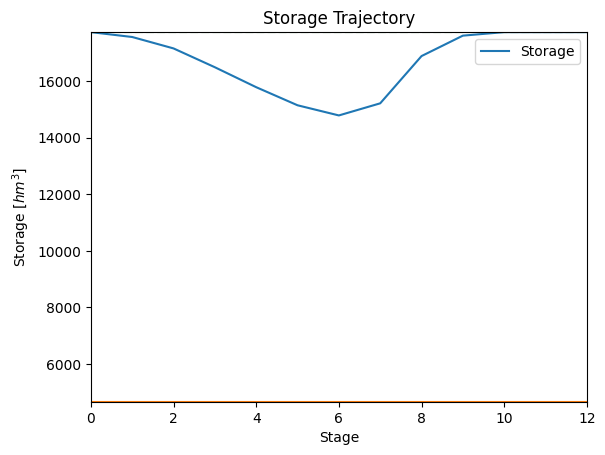

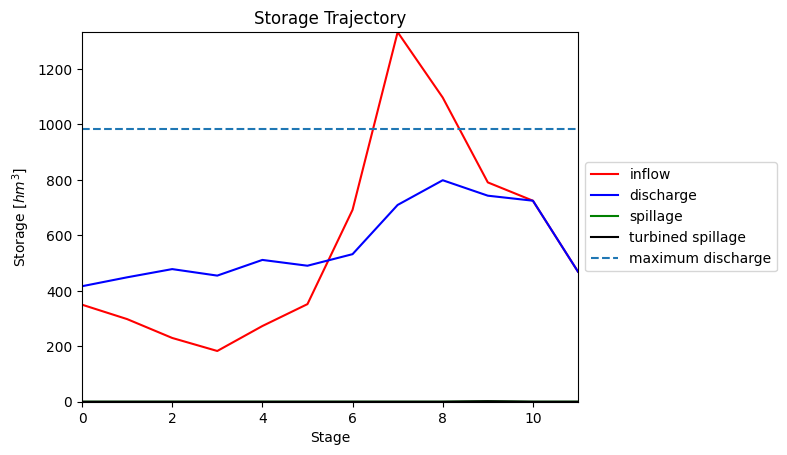

<Figure size 640x480 with 0 Axes>

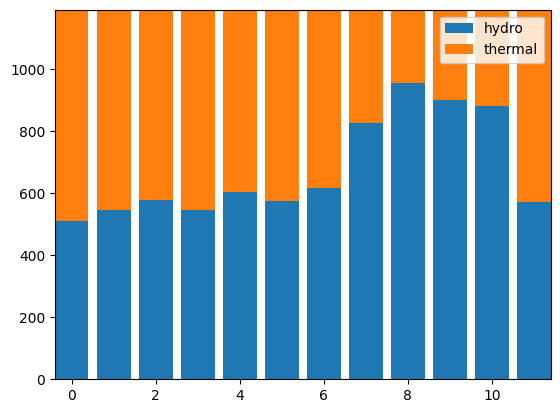

<Figure size 640x480 with 0 Axes>

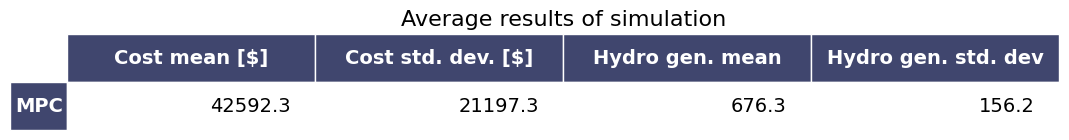

In [6]:
# Simulation
main()


In [7]:
# To run only one otimization:
plant = 1
m_initial = 5  # First month
m_final = 6
y_initial = 1  # First year of data inflows
y_final = 2
h = 36  # otm horizon

if plant == 1:
    for_coef_sob = np.array([5.680898E+02, 1.450600E-02, -1.202799E-06,
                             5.830299E-11, -1.124500E-15])
    tail_coef_sob = np.array([5.193198E+02, 3.939997E-03, -3.599999E-07,
                              4.329999E-11, -2.600000E-15])
    uhe = ModelParameters('emborcacao', 1192, 4669, 17725, 0, 984.5,
                           0.008731, tail_coef_sob, for_coef_sob)

x0=uhe.xmax # initial storage

w_now = uhe.vaz[y_initial, m_initial]
wpred = []
for i in range(int(h / 12)):
    wpred0 = np.concatenate((uhe.w_avg[m_initial:12], uhe.w_avg[0:m_initial]))
    wpred = np.concatenate((wpred, wpred0))

# first inflow is known (hazard-decision model)
wpred[0] = w_now

sim = Simulation(m_initial, m_final, y_initial, y_final, x0, h = h)
prob1 = Prob(uhe, h, m_initial, x0, wpred)

ini_rodada = time()

q, info, x_opt = sim.optimizer(uhe, x0, wpred, prob1)

print('Optimization completed on: '+
       str((time() - ini_rodada) / 60) + ' min \n')


NameError: name 'm_final' is not defined

In [ ]:
q

In [ ]:
info